# Data Cleaning & EDA Sign Language Recognition

**Setup**

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# CSV File

This file includes a list of all recorded sequences. Each row denotes one sequence and has information about participant_id and target sign.

* We have around **95000 sequences**.
* They show **250 signs**. Each sign is shown approximately 300 to 400 times.
* The sequences were recorded by **21 participants**. Each participant contributed 3500 to 5000 sequences. 

We add the label numbers to the signs in a column called **"target"**.

* There are no duplicate rows. 
* There are no missing values.


In [12]:
#import csv file with train targets

#train_df = pd.read_csv('/Users/ronjaweiblen/Bootcamp/Capstone_Project_SignMeUp/data/asl-signs/train.csv')
train_df = pd.read_csv('../data/asl-signs/train.csv')
train_df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [13]:
train_df.shape

(94477, 4)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


In [15]:
train_df[['sign', 'participant_id']].groupby('sign').count().sort_values(by='participant_id')

,participant_id
sign,
zipper,299
vacuum,307
beside,310
person,312
dance,312
...,...
mouse,408
donkey,410
shhh,411


<AxesSubplot:xlabel='sign'>

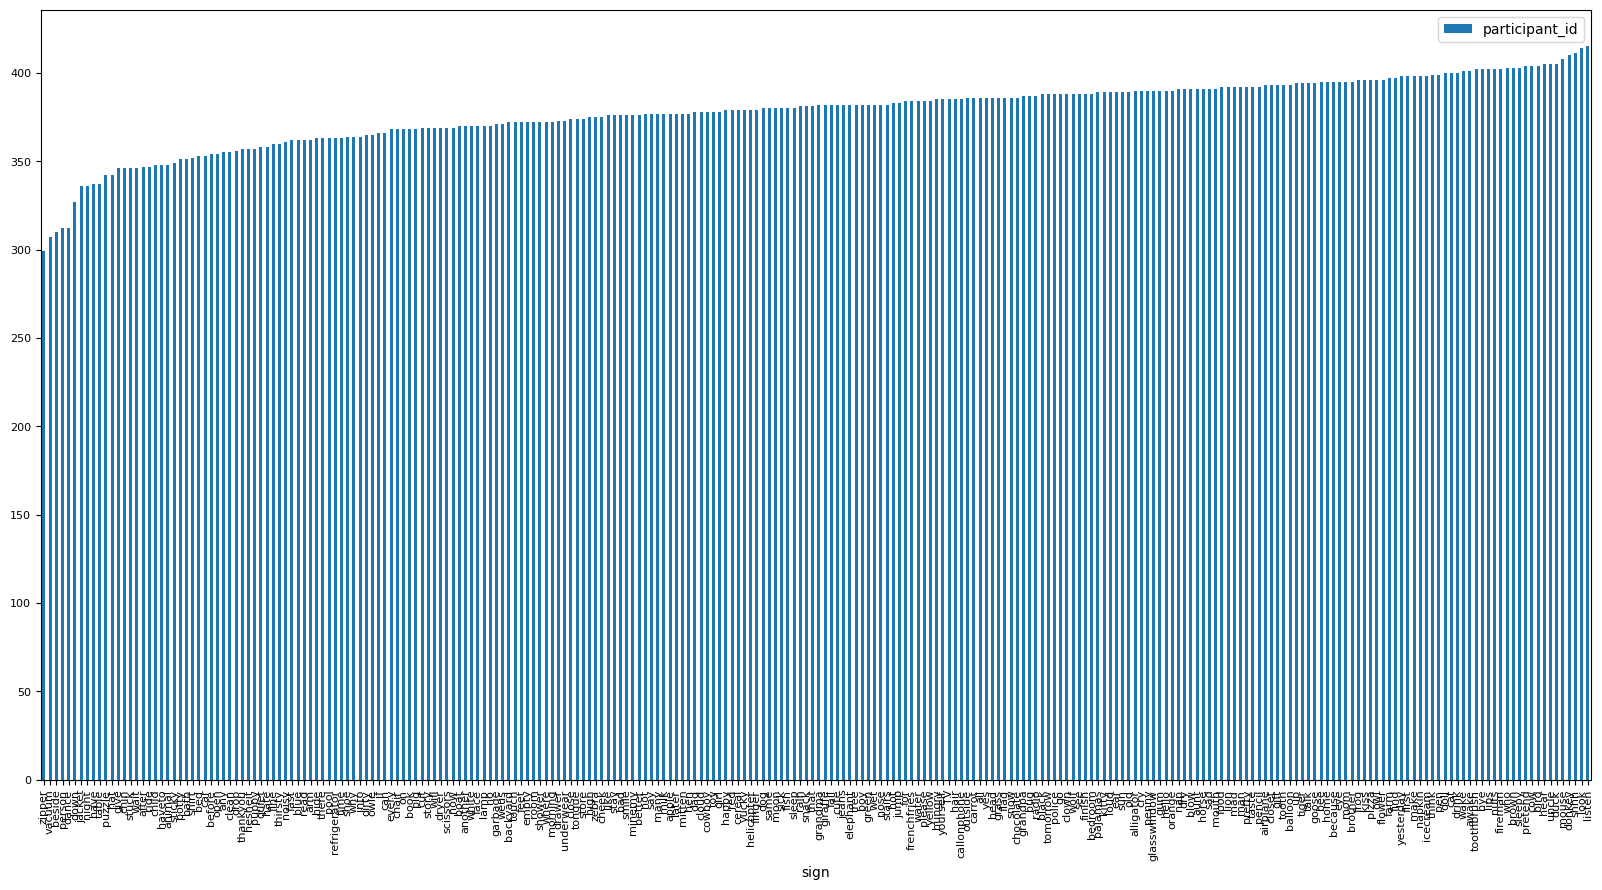

In [16]:
train_df[['sign', 'participant_id']].groupby('sign').count().sort_values(by='participant_id').plot(kind='bar', figsize=(20,10), fontsize=8)

The signs are quite evenly distributed (no imbalance), however it is always a good idea to stratify during train test splitting. Especially, when working with a subset of the data. 

In [17]:
# check for duplicates
train_df.duplicated().sum()

0

In [18]:
train_df[['participant_id', 'sign']].groupby('participant_id').count()

,sign
participant_id,
2044,4810
4718,3499
16069,4848
18796,3502
22343,4677
25571,3865
26734,4841
27610,4275
28656,4563


<AxesSubplot:xlabel='sign'>

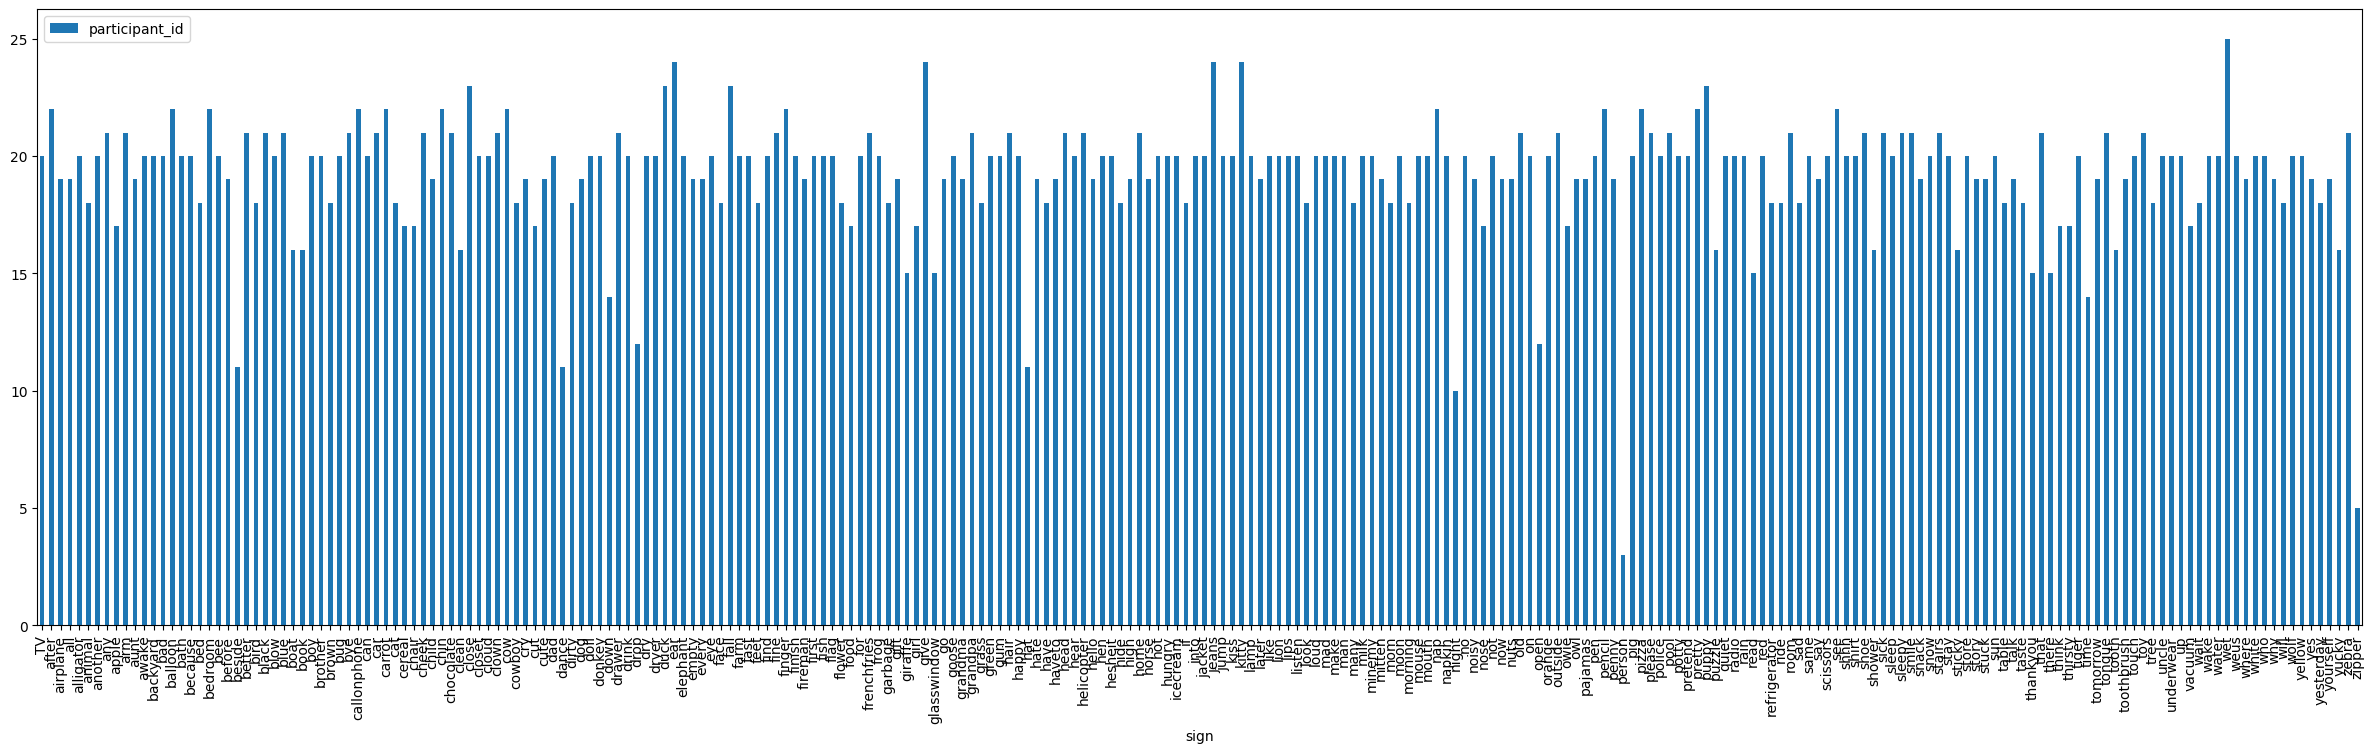

In [19]:
#one example participant
train_df[['participant_id', 'sign']].query('participant_id == 2044').groupby('sign').count().plot(kind='bar', figsize=(30,8))

In [74]:
train_df[['participant_id', 'sign']].query('participant_id == 2044').groupby('sign').count().sort_values("participant_id")

,participant_id
sign,
person,3
zipper,5
night,10
dance,11
beside,11
...,...
ear,24
kitty,24
jeans,24


When looking at the distribution for a single participant, we can already observe some imbalances, e.g. 
person	3
zipper	5
night	10
dance	11
beside	11

**Adding the label numbers to the table**

In [21]:
"""
import json
 
# Opening JSON file
with open('../data/asl-signs/sign_to_prediction_index_map.json') as json_file:
    sign_map = json.load(json_file)
"""

"\n# importing the module\nimport json\n \n# Opening JSON file\nwith open('../data/asl-signs/sign_to_prediction_index_map.json') as json_file:\n    sign_map = json.load(json_file)\n"

In [22]:
sign_map = {"TV": 0, "after": 1, "airplane": 2, "all": 3, "alligator": 4, "animal": 5, "another": 6, "any": 7, "apple": 8, "arm": 9, "aunt": 10, "awake": 11, "backyard": 12, "bad": 13, "balloon": 14, "bath": 15, "because": 16, "bed": 17, "bedroom": 18, "bee": 19, "before": 20, "beside": 21, "better": 22, "bird": 23, "black": 24, "blow": 25, "blue": 26, "boat": 27, "book": 28, "boy": 29, "brother": 30, "brown": 31, "bug": 32, "bye": 33, "callonphone": 34, "can": 35, "car": 36, "carrot": 37, "cat": 38, "cereal": 39, "chair": 40, "cheek": 41, "child": 42, "chin": 43, "chocolate": 44, "clean": 45, "close": 46, "closet": 47, "cloud": 48, "clown": 49, "cow": 50, "cowboy": 51, "cry": 52, "cut": 53, "cute": 54, "dad": 55, "dance": 56, "dirty": 57, "dog": 58, "doll": 59, "donkey": 60, "down": 61, "drawer": 62, "drink": 63, "drop": 64, "dry": 65, "dryer": 66, "duck": 67, "ear": 68, "elephant": 69, "empty": 70, "every": 71, "eye": 72, "face": 73, "fall": 74, "farm": 75, "fast": 76, "feet": 77, "find": 78, "fine": 79, "finger": 80, "finish": 81, "fireman": 82, "first": 83, "fish": 84, "flag": 85, "flower": 86, "food": 87, "for": 88, "frenchfries": 89, "frog": 90, "garbage": 91, "gift": 92, "giraffe": 93, "girl": 94, "give": 95, "glasswindow": 96, "go": 97, "goose": 98, "grandma": 99, "grandpa": 100, "grass": 101, "green": 102, "gum": 103, "hair": 104, "happy": 105, "hat": 106, "hate": 107, "have": 108, "haveto": 109, "head": 110, "hear": 111, "helicopter": 112, "hello": 113, "hen": 114, "hesheit": 115, "hide": 116, "high": 117, "home": 118, "horse": 119, "hot": 120, "hungry": 121, "icecream": 122, "if": 123, "into": 124, "jacket": 125, "jeans": 126, "jump": 127, "kiss": 128, "kitty": 129, "lamp": 130, "later": 131, "like": 132, "lion": 133, "lips": 134, "listen": 135, "look": 136, "loud": 137, "mad": 138, "make": 139, "man": 140, "many": 141, "milk": 142, "minemy": 143, "mitten": 144, "mom": 145, "moon": 146, "morning": 147, "mouse": 148, "mouth": 149, "nap": 150, "napkin": 151, "night": 152, "no": 153, "noisy": 154, "nose": 155, "not": 156, "now": 157, "nuts": 158, "old": 159, "on": 160, "open": 161, "orange": 162, "outside": 163, "owie": 164, "owl": 165, "pajamas": 166, "pen": 167, "pencil": 168, "penny": 169, "person": 170, "pig": 171, "pizza": 172, "please": 173, "police": 174, "pool": 175, "potty": 176, "pretend": 177, "pretty": 178, "puppy": 179, "puzzle": 180, "quiet": 181, "radio": 182, "rain": 183, "read": 184, "red": 185, "refrigerator": 186, "ride": 187, "room": 188, "sad": 189, "same": 190, "say": 191, "scissors": 192, "see": 193, "shhh": 194, "shirt": 195, "shoe": 196, "shower": 197, "sick": 198, "sleep": 199, "sleepy": 200, "smile": 201, "snack": 202, "snow": 203, "stairs": 204, "stay": 205, "sticky": 206, "store": 207, "story": 208, "stuck": 209, "sun": 210, "table": 211, "talk": 212, "taste": 213, "thankyou": 214, "that": 215, "there": 216, "think": 217, "thirsty": 218, "tiger": 219, "time": 220, "tomorrow": 221, "tongue": 222, "tooth": 223, "toothbrush": 224, "touch": 225, "toy": 226, "tree": 227, "uncle": 228, "underwear": 229, "up": 230, "vacuum": 231, "wait": 232, "wake": 233, "water": 234, "wet": 235, "weus": 236, "where": 237, "white": 238, "who": 239, "why": 240, "will": 241, "wolf": 242, "yellow": 243, "yes": 244, "yesterday": 245, "yourself": 246, "yucky": 247, "zebra": 248, "zipper": 249}

# applying dictionary on sign to create target column
train_df['target'] = train_df.sign.map(sign_map)
train_df.head()

,path,participant_id,sequence_id,sign,target
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164


In [23]:
train_df.describe()

,participant_id,sequence_id,target
count,94477.000000,9.447700e+04,94477.000000
mean,33678.632366,2.149377e+09,124.403125
std,16138.124387,1.239239e+09,71.988014
min,2044.000000,8.528200e+04,0.000000
25%,25571.000000,1.078076e+09,62.000000
50%,32319.000000,2.154240e+09,124.000000
75%,49445.000000,3.218820e+09,187.000000
max,62590.000000,4.294915e+09,249.000000


In [24]:
train_df.isna().sum()

path              0
participant_id    0
sequence_id       0
sign              0
target            0
dtype: int64

In [25]:
train_df.nunique()

path              94477
participant_id       21
sequence_id       94477
sign                250
target              250
dtype: int64

# Parquet files

1. We read in a subset of the parquet files and make one big table.

In [26]:
#choose a subset of participants
subs = train_df.query("participant_id <= 5000") #takes 2 participants
#subs = subs.query("sign == 'tiger' or sign == 'pencil' or sign == 'sleepy' or sign == 'grandma' or sign == 'chocolate'")#takes 5 signs

In [27]:
sign_list = ['alligator', 'radio', 'moon', 'sleep', 'grandpa', 'tiger', 'pencil', 'sleepy', 'grandma', 'chocolate']
# Limiting dataset to 5 signs from sign_list
subs=subs[subs['sign'].isin(sign_list)]
subs.head()

,path,participant_id,sequence_id,sign,target
214,train_landmark_files/2044/1008623492.parquet,2044,1008623492,sleepy,200
339,train_landmark_files/4718/1013877443.parquet,4718,1013877443,radio,182
472,train_landmark_files/2044/101990054.parquet,2044,101990054,grandpa,100
614,train_landmark_files/2044/1025699944.parquet,2044,1025699944,pencil,168
973,train_landmark_files/2044/1040944803.parquet,2044,1040944803,chocolate,44


In [75]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 214 to 94430
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            342 non-null    object
 1   participant_id  342 non-null    int64 
 2   sequence_id     342 non-null    int64 
 3   sign            342 non-null    object
 4   target          342 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 16.0+ KB


Final subset consists of 342 data points derived from participants 2044 and 4718 for the signs 'alligator', 'radio', 'moon', 'sleep', 'grandpa', 'tiger', 'pencil', 'sleepy', 'grandma' and 'chocolate'. 

In [28]:
#read in all parquet files
df = pd.DataFrame() #initialize empty dataframe

for i in range(len(subs)):
    p = subs.iloc[i, 0] # path 
    s = subs.iloc[i, 4] # sign target value (numeric)
    data = pd.read_parquet('../data/asl-signs/'+p)
    data['sign'] = s
    data['sequence_id'] = subs.iloc[i, 2]
    df = pd.concat([df, data], axis = 0)

In [29]:
df.head()

,frame,row_id,type,landmark_index,x,y,z,sign,sequence_id
0,27,27-face-0,face,0,0.471821,0.520759,-0.043933,200,1008623492
1,27,27-face-1,face,1,0.465683,0.483549,-0.069072,200,1008623492
2,27,27-face-2,face,2,0.470130,0.496350,-0.039444,200,1008623492
3,27,27-face-3,face,3,0.454756,0.451838,-0.044519,200,1008623492
4,27,27-face-4,face,4,0.464215,0.472658,-0.071946,200,1008623492


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4602468 entries, 0 to 2714
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   frame           int16  
 1   row_id          object 
 2   type            object 
 3   landmark_index  int16  
 4   x               float64
 5   y               float64
 6   z               float64
 7   sign            int64  
 8   sequence_id     int64  
dtypes: float64(3), int16(2), int64(2), object(2)
memory usage: 298.5+ MB


In [31]:
df.shape

(4602468, 9)

In [32]:
df.nunique()

frame                 139
row_id              75477
type                    4
landmark_index        468
x                 3212338
y                 3350963
z                 4193750
sign                   10
sequence_id           342
dtype: int64

**Drop some columns we don't need**

In [80]:
#drop z
df = df.drop('z', axis = 1)

#drop row_id
df = df.drop('row_id', axis = 1)

df.head()

,frame,type,landmark_index,x,y,sign,sequence_id,idx
0,27,face,0,0.471821,0.520759,200,1008623492,1
1,27,face,1,0.465683,0.483549,200,1008623492,2
2,27,face,2,0.470130,0.496350,200,1008623492,3
3,27,face,3,0.454756,0.451838,200,1008623492,4
4,27,face,4,0.464215,0.472658,200,1008623492,5


**Make one row per frame**

In [34]:
#make one row per frame with all the landmarks 

df_wide = df
df_wide['idx'] = df_wide.groupby('sequence_id').cumcount()+1
df_wide = df_wide.pivot_table(index=['sequence_id', 'frame', 'sign'], columns=['landmark_index', 'type'], 
                    values=['x', 'y'], aggfunc='first')

df_wide = df_wide.sort_index(axis=1, level=1)
df_wide.columns = [f'{x}_{y}_{z}' for x,y,z in df_wide.columns]
df_wide = df_wide.reset_index()

df_wide.head(25)

,sequence_id,frame,sign,x_0_face,x_0_left_hand,x_0_pose,x_0_right_hand,y_0_face,y_0_left_hand,y_0_pose,...,x_463_face,y_463_face,x_464_face,y_464_face,x_465_face,y_465_face,x_466_face,y_466_face,x_467_face,y_467_face
0,1103626,66,199,0.499451,NaN,0.501808,0.217661,0.498785,NaN,0.471588,...,0.515027,0.410778,0.507427,0.412490,0.502100,0.413208,0.568416,0.406694,0.576702,0.400996
1,1103626,67,199,0.503057,NaN,0.502046,0.217384,0.498326,NaN,0.471359,...,0.516932,0.410217,0.509416,0.412111,0.504165,0.413036,0.570616,0.408106,0.579115,0.402548
2,1103626,68,199,0.498503,NaN,0.500202,0.232187,0.492894,NaN,0.470101,...,0.516855,0.404900,0.509602,0.406607,0.504426,0.407471,0.571150,0.401490,0.579352,0.395687
3,1103626,69,199,0.497872,NaN,0.500074,0.245714,0.493547,NaN,0.469292,...,0.517090,0.404000,0.509797,0.405742,0.504594,0.406594,0.570517,0.401718,0.578996,0.395893
4,1103626,70,199,0.496797,NaN,0.500010,0.237343,0.493915,NaN,0.468621,...,0.517655,0.404046,0.510405,0.405896,0.505086,0.406796,0.570904,0.401564,0.579153,0.395694
5,1103626,71,199,0.497491,NaN,0.499923,NaN,0.494140,NaN,0.468269,...,0.517280,0.404298,0.510141,0.406231,0.505064,0.407197,0.571840,0.401913,0.580006,0.396042
6,1103626,72,199,0.507282,NaN,0.505718,0.236104,0.490735,NaN,0.468028,...,0.524972,0.405545,0.517644,0.406927,0.512656,0.407296,0.577797,0.404138,0.586765,0.398753
7,1103626,73,199,0.503771,NaN,0.509427,0.250016,0.491537,NaN,0.468039,...,0.526079,0.405016,0.518391,0.406482,0.513029,0.406846,0.578356,0.403894,0.587102,0.398625
8,1103626,74,199,0.504653,NaN,0.509859,0.254741,0.491700,NaN,0.467854,...,0.524164,0.404723,0.516795,0.406412,0.511808,0.406917,0.578217,0.404078,0.587225,0.398615
9,1103626,75,199,0.506082,NaN,0.509362,0.259021,0.491335,NaN,0.466975,...,0.525744,0.405126,0.518048,0.406499,0.512709,0.406735,0.578701,0.404027,0.587649,0.398758


**Deal with NaN**

* set missing values where the whole sequence is missing to 0
* interpolate other NaN

In [35]:
df_wide.isna().sum()

sequence_id         0
frame               0
sign                0
x_0_face           20
x_0_left_hand    8464
                 ... 
y_465_face         20
x_466_face         20
y_466_face         20
x_467_face         20
y_467_face         20
Length: 1089, dtype: int64

* Interpolate NaNs linearly from their neighbors. 
* If there are more than 2 consecutive NaN, don´t impute them. We will later set them to 0.
* Inerpolation should only be done per sequence --° group by sequence first

In [36]:
#before: NaN in x_0_right hand, row 5 
df_wide.head(10)

,sequence_id,frame,sign,x_0_face,x_0_left_hand,x_0_pose,x_0_right_hand,y_0_face,y_0_left_hand,y_0_pose,...,x_463_face,y_463_face,x_464_face,y_464_face,x_465_face,y_465_face,x_466_face,y_466_face,x_467_face,y_467_face
0,1103626,66,199,0.499451,NaN,0.501808,0.217661,0.498785,NaN,0.471588,...,0.515027,0.410778,0.507427,0.412490,0.502100,0.413208,0.568416,0.406694,0.576702,0.400996
1,1103626,67,199,0.503057,NaN,0.502046,0.217384,0.498326,NaN,0.471359,...,0.516932,0.410217,0.509416,0.412111,0.504165,0.413036,0.570616,0.408106,0.579115,0.402548
2,1103626,68,199,0.498503,NaN,0.500202,0.232187,0.492894,NaN,0.470101,...,0.516855,0.404900,0.509602,0.406607,0.504426,0.407471,0.571150,0.401490,0.579352,0.395687
3,1103626,69,199,0.497872,NaN,0.500074,0.245714,0.493547,NaN,0.469292,...,0.517090,0.404000,0.509797,0.405742,0.504594,0.406594,0.570517,0.401718,0.578996,0.395893
4,1103626,70,199,0.496797,NaN,0.500010,0.237343,0.493915,NaN,0.468621,...,0.517655,0.404046,0.510405,0.405896,0.505086,0.406796,0.570904,0.401564,0.579153,0.395694
5,1103626,71,199,0.497491,NaN,0.499923,NaN,0.494140,NaN,0.468269,...,0.517280,0.404298,0.510141,0.406231,0.505064,0.407197,0.571840,0.401913,0.580006,0.396042
6,1103626,72,199,0.507282,NaN,0.505718,0.236104,0.490735,NaN,0.468028,...,0.524972,0.405545,0.517644,0.406927,0.512656,0.407296,0.577797,0.404138,0.586765,0.398753
7,1103626,73,199,0.503771,NaN,0.509427,0.250016,0.491537,NaN,0.468039,...,0.526079,0.405016,0.518391,0.406482,0.513029,0.406846,0.578356,0.403894,0.587102,0.398625
8,1103626,74,199,0.504653,NaN,0.509859,0.254741,0.491700,NaN,0.467854,...,0.524164,0.404723,0.516795,0.406412,0.511808,0.406917,0.578217,0.404078,0.587225,0.398615
9,1103626,75,199,0.506082,NaN,0.509362,0.259021,0.491335,NaN,0.466975,...,0.525744,0.405126,0.518048,0.406499,0.512709,0.406735,0.578701,0.404027,0.587649,0.398758


In [37]:
#use interpolate method for single missing values
df_wide = df_wide.groupby('sequence_id').apply(lambda group: group.interpolate(limit = 2, limit_direction = 'both'))
df_wide.head(10)

,sequence_id,frame,sign,x_0_face,x_0_left_hand,x_0_pose,x_0_right_hand,y_0_face,y_0_left_hand,y_0_pose,...,x_463_face,y_463_face,x_464_face,y_464_face,x_465_face,y_465_face,x_466_face,y_466_face,x_467_face,y_467_face
0,1103626,66,199,0.499451,NaN,0.501808,0.217661,0.498785,NaN,0.471588,...,0.515027,0.410778,0.507427,0.412490,0.502100,0.413208,0.568416,0.406694,0.576702,0.400996
1,1103626,67,199,0.503057,NaN,0.502046,0.217384,0.498326,NaN,0.471359,...,0.516932,0.410217,0.509416,0.412111,0.504165,0.413036,0.570616,0.408106,0.579115,0.402548
2,1103626,68,199,0.498503,NaN,0.500202,0.232187,0.492894,NaN,0.470101,...,0.516855,0.404900,0.509602,0.406607,0.504426,0.407471,0.571150,0.401490,0.579352,0.395687
3,1103626,69,199,0.497872,NaN,0.500074,0.245714,0.493547,NaN,0.469292,...,0.517090,0.404000,0.509797,0.405742,0.504594,0.406594,0.570517,0.401718,0.578996,0.395893
4,1103626,70,199,0.496797,NaN,0.500010,0.237343,0.493915,NaN,0.468621,...,0.517655,0.404046,0.510405,0.405896,0.505086,0.406796,0.570904,0.401564,0.579153,0.395694
5,1103626,71,199,0.497491,NaN,0.499923,0.236723,0.494140,NaN,0.468269,...,0.517280,0.404298,0.510141,0.406231,0.505064,0.407197,0.571840,0.401913,0.580006,0.396042
6,1103626,72,199,0.507282,NaN,0.505718,0.236104,0.490735,NaN,0.468028,...,0.524972,0.405545,0.517644,0.406927,0.512656,0.407296,0.577797,0.404138,0.586765,0.398753
7,1103626,73,199,0.503771,NaN,0.509427,0.250016,0.491537,NaN,0.468039,...,0.526079,0.405016,0.518391,0.406482,0.513029,0.406846,0.578356,0.403894,0.587102,0.398625
8,1103626,74,199,0.504653,NaN,0.509859,0.254741,0.491700,NaN,0.467854,...,0.524164,0.404723,0.516795,0.406412,0.511808,0.406917,0.578217,0.404078,0.587225,0.398615
9,1103626,75,199,0.506082,NaN,0.509362,0.259021,0.491335,NaN,0.466975,...,0.525744,0.405126,0.518048,0.406499,0.512709,0.406735,0.578701,0.404027,0.587649,0.398758


In [38]:
#replace the rest of the NaN with 0
df_wide.fillna(0, inplace = True)
df_wide.head(10)

,sequence_id,frame,sign,x_0_face,x_0_left_hand,x_0_pose,x_0_right_hand,y_0_face,y_0_left_hand,y_0_pose,...,x_463_face,y_463_face,x_464_face,y_464_face,x_465_face,y_465_face,x_466_face,y_466_face,x_467_face,y_467_face
0,1103626,66,199,0.499451,0.0,0.501808,0.217661,0.498785,0.0,0.471588,...,0.515027,0.410778,0.507427,0.412490,0.502100,0.413208,0.568416,0.406694,0.576702,0.400996
1,1103626,67,199,0.503057,0.0,0.502046,0.217384,0.498326,0.0,0.471359,...,0.516932,0.410217,0.509416,0.412111,0.504165,0.413036,0.570616,0.408106,0.579115,0.402548
2,1103626,68,199,0.498503,0.0,0.500202,0.232187,0.492894,0.0,0.470101,...,0.516855,0.404900,0.509602,0.406607,0.504426,0.407471,0.571150,0.401490,0.579352,0.395687
3,1103626,69,199,0.497872,0.0,0.500074,0.245714,0.493547,0.0,0.469292,...,0.517090,0.404000,0.509797,0.405742,0.504594,0.406594,0.570517,0.401718,0.578996,0.395893
4,1103626,70,199,0.496797,0.0,0.500010,0.237343,0.493915,0.0,0.468621,...,0.517655,0.404046,0.510405,0.405896,0.505086,0.406796,0.570904,0.401564,0.579153,0.395694
5,1103626,71,199,0.497491,0.0,0.499923,0.236723,0.494140,0.0,0.468269,...,0.517280,0.404298,0.510141,0.406231,0.505064,0.407197,0.571840,0.401913,0.580006,0.396042
6,1103626,72,199,0.507282,0.0,0.505718,0.236104,0.490735,0.0,0.468028,...,0.524972,0.405545,0.517644,0.406927,0.512656,0.407296,0.577797,0.404138,0.586765,0.398753
7,1103626,73,199,0.503771,0.0,0.509427,0.250016,0.491537,0.0,0.468039,...,0.526079,0.405016,0.518391,0.406482,0.513029,0.406846,0.578356,0.403894,0.587102,0.398625
8,1103626,74,199,0.504653,0.0,0.509859,0.254741,0.491700,0.0,0.467854,...,0.524164,0.404723,0.516795,0.406412,0.511808,0.406917,0.578217,0.404078,0.587225,0.398615
9,1103626,75,199,0.506082,0.0,0.509362,0.259021,0.491335,0.0,0.466975,...,0.525744,0.405126,0.518048,0.406499,0.512709,0.406735,0.578701,0.404027,0.587649,0.398758


In [39]:
#check
df_wide.isna().sum()

sequence_id      0
frame            0
sign             0
x_0_face         0
x_0_left_hand    0
                ..
y_465_face       0
x_466_face       0
y_466_face       0
x_467_face       0
y_467_face       0
Length: 1089, dtype: int64

**Reassign frame index so it starts from 0**

In [40]:
#give frames a new index starting from 0
df_wide["frame_index"] = df_wide.groupby("sequence_id").cumcount()
df_wide = df_wide.drop('frame', axis = 1)
df_wide.head(25)

,sequence_id,sign,x_0_face,x_0_left_hand,x_0_pose,x_0_right_hand,y_0_face,y_0_left_hand,y_0_pose,y_0_right_hand,...,y_463_face,x_464_face,y_464_face,x_465_face,y_465_face,x_466_face,y_466_face,x_467_face,y_467_face,frame_index
0,1103626,199,0.499451,0.0,0.501808,0.217661,0.498785,0.0,0.471588,0.779989,...,0.410778,0.507427,0.412490,0.502100,0.413208,0.568416,0.406694,0.576702,0.400996,0
1,1103626,199,0.503057,0.0,0.502046,0.217384,0.498326,0.0,0.471359,0.788098,...,0.410217,0.509416,0.412111,0.504165,0.413036,0.570616,0.408106,0.579115,0.402548,1
2,1103626,199,0.498503,0.0,0.500202,0.232187,0.492894,0.0,0.470101,0.793298,...,0.404900,0.509602,0.406607,0.504426,0.407471,0.571150,0.401490,0.579352,0.395687,2
3,1103626,199,0.497872,0.0,0.500074,0.245714,0.493547,0.0,0.469292,0.793983,...,0.404000,0.509797,0.405742,0.504594,0.406594,0.570517,0.401718,0.578996,0.395893,3
4,1103626,199,0.496797,0.0,0.500010,0.237343,0.493915,0.0,0.468621,0.787126,...,0.404046,0.510405,0.405896,0.505086,0.406796,0.570904,0.401564,0.579153,0.395694,4
5,1103626,199,0.497491,0.0,0.499923,0.236723,0.494140,0.0,0.468269,0.796227,...,0.404298,0.510141,0.406231,0.505064,0.407197,0.571840,0.401913,0.580006,0.396042,5
6,1103626,199,0.507282,0.0,0.505718,0.236104,0.490735,0.0,0.468028,0.805328,...,0.405545,0.517644,0.406927,0.512656,0.407296,0.577797,0.404138,0.586765,0.398753,6
7,1103626,199,0.503771,0.0,0.509427,0.250016,0.491537,0.0,0.468039,0.810728,...,0.405016,0.518391,0.406482,0.513029,0.406846,0.578356,0.403894,0.587102,0.398625,7
8,1103626,199,0.504653,0.0,0.509859,0.254741,0.491700,0.0,0.467854,0.807701,...,0.404723,0.516795,0.406412,0.511808,0.406917,0.578217,0.404078,0.587225,0.398615,8
9,1103626,199,0.506082,0.0,0.509362,0.259021,0.491335,0.0,0.466975,0.806324,...,0.405126,0.518048,0.406499,0.512709,0.406735,0.578701,0.404027,0.587649,0.398758,9


**Make sure all sequences have the same length**

Longest videos are up to 138 frames.

50 % range between 6 and 34.--> Which ones should we exclude?

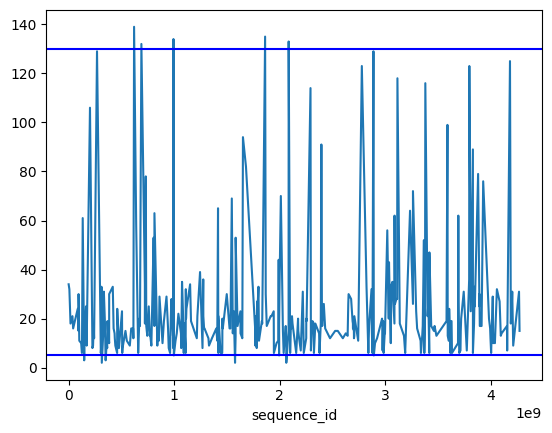

In [41]:
df_wide.groupby('sequence_id').count()['frame_index'].plot() #does this make sense
# only one line may be specified; full height
plt.axhline(y = 5, color = 'b', label = 'axvline - full height')
plt.axhline(y = 130, color = 'b', label = 'axvline - full height')

In [42]:
numofframes = df_wide.groupby('sequence_id').count()['frame_index']
numofframes.sort_values(ascending=True)


sequence_id
1577832107      2
315243057       2
2063434570      2
351486830       3
148526448       3
             ... 
690456887     132
2085945934    133
994309330     134
1862716737    135
621161958     139
Name: frame_index, Length: 342, dtype: int64

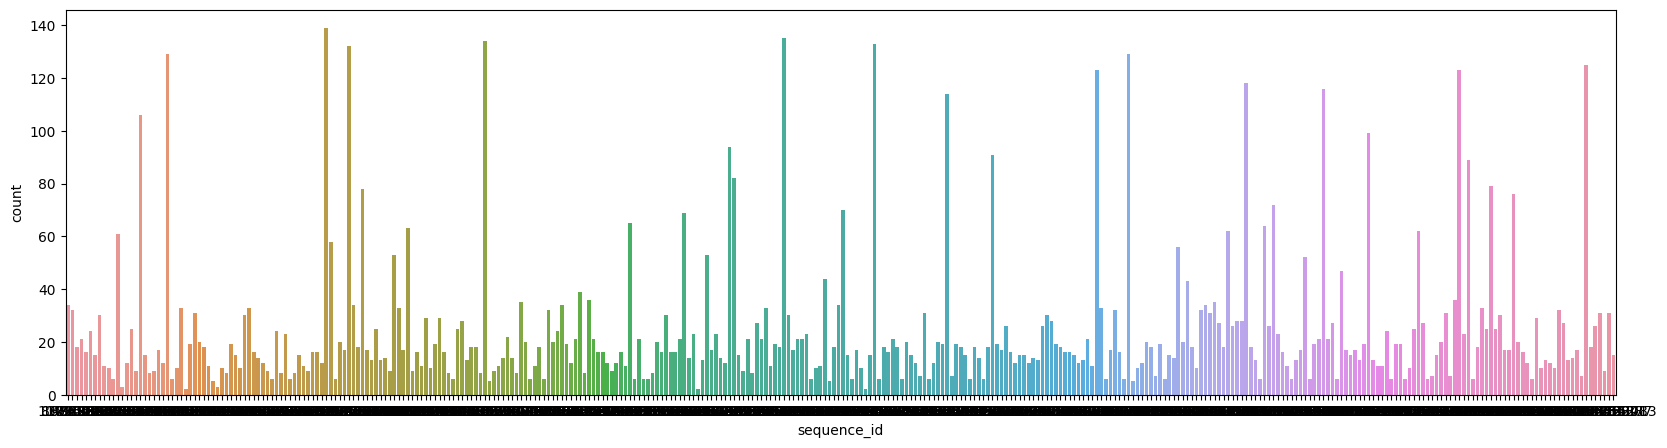

In [43]:
#plot number of frames per sequence
fig, ax = plt.subplots(figsize=(20, 5))
 
# drawing the plot
sns.countplot(x = df_wide['sequence_id'],  ax=ax)
plt.show()

*Are the videos different lengths depending on the sign?*

Not really, at least not with these signs.

/Users/jin-holee/neuefische/Capstone_Project_SignMeUp/.venv/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


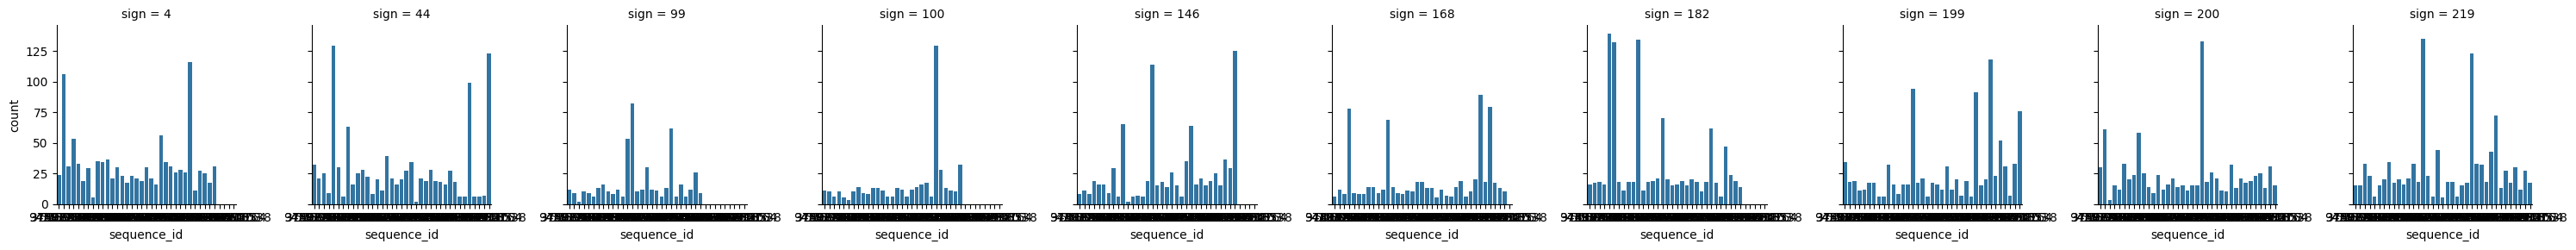

In [44]:
#plot number of frames per sequence and sign
#fig, ax = plt.subplots(figsize=(5, 20))
 
# drawing the plot
g = sns.FacetGrid(df_wide, col="sign")
g.map(sns.countplot, 'sequence_id')
plt.show()

**Dropping sequences with too few frames**



In [45]:
df_wide.sequence_id.nunique()

342

Before removing we have 342 sequences.

In [46]:
#drop sequences with less than 5 frames
df_wide = df_wide.groupby('sequence_id').filter(lambda x : len(x)>4)
df_wide.sequence_id.nunique()

337

Filtering removes 5 sequences

**Dropping(?) sequences with too many frames**

In [47]:
#cut off sequences after frame 130 

#just for now so I can do the padding


In [48]:
df_wide = df_wide.groupby('sequence_id').filter(lambda x : len(x)<131)
df_wide.sequence_id.nunique()

332

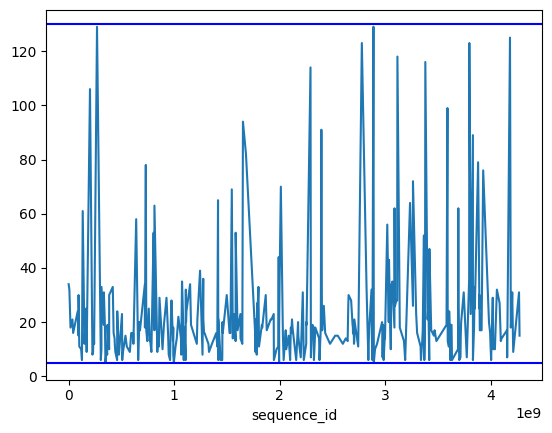

In [49]:
df_wide.groupby('sequence_id').count()['frame_index'].plot() #does this make sense
# only one line may be specified; full height
plt.axhline(y = 5, color = 'b', label = 'axvline - full height')
plt.axhline(y = 130, color = 'b', label = 'axvline - full height')

In [50]:
df_wide.shape

(7791, 1089)

**Zero-padding to same length**

In [87]:
#we have to make sequences first for this to work

#decide which columns are of interest
FEATURE_COLUMNS = df_wide.columns.to_list()[2:-1]
FEATURE_COLUMNS

#check last item
last = FEATURE_COLUMNS[-1]
last

'y_467_face'

In [52]:
#make sequences
sequences= list()

for sequence_id, group in df_wide.groupby('sequence_id'):
    sequence_features = group[FEATURE_COLUMNS]
    #label = df_wide[df_wide.sequence_id == sequence_id].iloc[0].sign #this would at the label to the sequence if we want that
    values = sequence_features.values 
    #sequences.append((sequence_features, label))
    sequences.append(values)

In [53]:
#look at one sequence
sequences[50].shape # this sequence has 9 frames with 1086 key points

(9, 1086)

In [54]:
# define function for padding

def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')


In [55]:

new_seq = []
for one_seq in sequences: #loop through all sequences
    new_one_seq = padding(one_seq,130, 1086)
    new_seq.append(new_one_seq)


final_seq = np.stack(new_seq)
final_seq[9]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
type(final_seq[5])

numpy.ndarray

In [57]:
final_seq[5].shape

(130, 1086)

In [58]:
#write function to truncate the middle data points of each sequence

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [59]:
crop_seq = []
for one_seq in final_seq: #loop through all sequences
    
    crop_one_seq = crop_center(one_seq,1086, 30)
    crop_seq.append(crop_one_seq)


cropped_seq = np.stack(crop_seq)
cropped_seq[9]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:
type(cropped_seq[5])

numpy.ndarray

In [61]:
cropped_seq[5].shape

(30, 1086)

In [62]:
cropped_seq.shape

(332, 30, 1086)

We now have a list of arrays with 30 frames and 1086 x & y values for the landmarks. 

Rename it X as this is what it is:)

In [63]:
X = cropped_seq

In [64]:
X.shape

(332, 30, 1086)

In [65]:
type(X)

numpy.ndarray

In [66]:
X[5].shape

(30, 1086)

In [67]:
df_wide.sequence_id.nunique()

332

In [68]:
# get corresponding y
y = df_wide.groupby('sequence_id')['sign'].agg(pd.Series.mode)
pd.DataFrame(y)
# get dummies because this is how the model wants the data
y = pd.get_dummies(y)

## Export datasets to numpy files for modeling

In [69]:
#save as numpy files
np.save('../data/y-data.npy', y)
np.save('../data/X-data.npy', X)

In [70]:
#loading in the numpy file 
X_testing = np.load('../data/X-data.npy')

In [71]:
# check the shapes:
print("shape of arr: ", X.shape)
print("shape of load_original_arr: ", X_testing.shape)

shape of arr:  (332, 30, 1086)
shape of load_original_arr:  (332, 30, 1086)
